In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR  

In [2]:
#Safe LabelEncoder để tránh lỗi KeyError
class SafeLabelEncoder(LabelEncoder):
    def transform(self, values):
        return [np.where(self.classes_ == val)[0][0] if val in self.classes_ else -1 for val in values]

In [4]:
# Đọc dữ liệu
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/validation.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [5]:
# 2. Hàm tiền xử lý
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # Cột phân loại & số
    categorical_cols = ['film_code', 'cinema_code', 'month', 'quarter', 'day', 'year']
    numerical_cols = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc', 'ticket_use', 'capacity']
    target_col = 'total_sales'

    # Encode cột phân loại
    if is_train:
        encoders = {col: SafeLabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))

    # Scale số
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])

    # Tập dữ liệu
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None

    return X, y, encoders, scaler

In [6]:
# 3. Chuẩn hóa dữ liệu 
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, _, _, _ = preprocess(test_df, encoders, scaler, is_train=False)


In [7]:
# Khởi tạo dataset cho PyTorch
class SalesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

train_data = SalesDataset(X_train, y_train)
valid_data = SalesDataset(X_valid, y_valid)
test_data = SalesDataset(X_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

# SVM Regressor
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Huấn luyện mô hình SVM
svm_model.fit(X_train, y_train)


SVR()

In [ ]:
val_preds = svm_model.predict(X_valid)
val_mae = mean_absolute_error(y_valid, val_preds)
val_mse = mean_squared_error(y_valid, val_preds)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_valid, val_preds)

print(f"[VALIDATION] MAE: {val_mae:.2f}, MSE: {val_mse:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.2f}")

# Test
test_preds = svm_model.predict(X_test)

# Nếu test_df có cột 'total_sales' (dùng để tính test_true), còn không thì bỏ đánh giá test
if 'total_sales' in test_df.columns:
    test_true = test_df['total_sales'].values
    test_mae = mean_absolute_error(test_true, test_preds)
    test_mse = mean_squared_error(test_true, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_true, test_preds)

    print(f"[TEST] MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")


[VALIDATION] MAE: 12979706.57, MSE: 1349920767684226.50, RMSE: 36741267.91, R²: -0.10
[TEST] MAE: 11084384.09, MSE: 1056609763968118.25, RMSE: 32505534.36, R²: -0.08


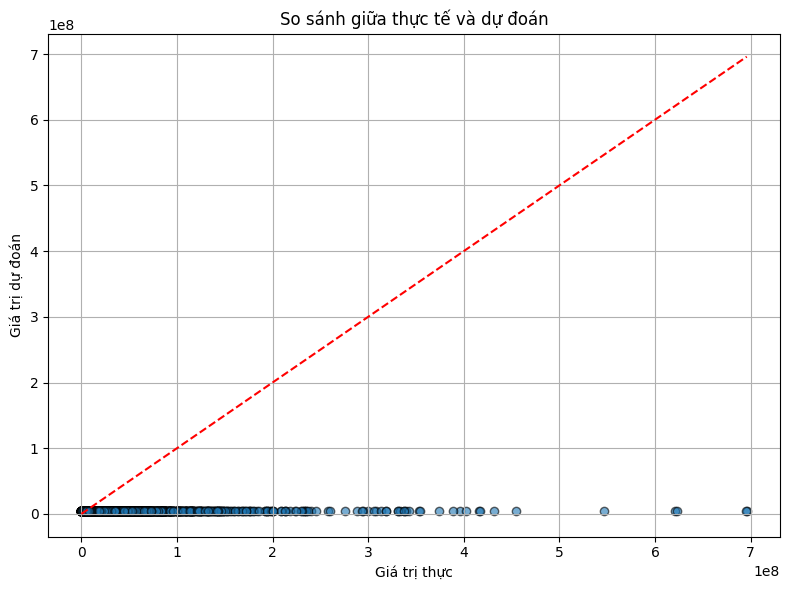

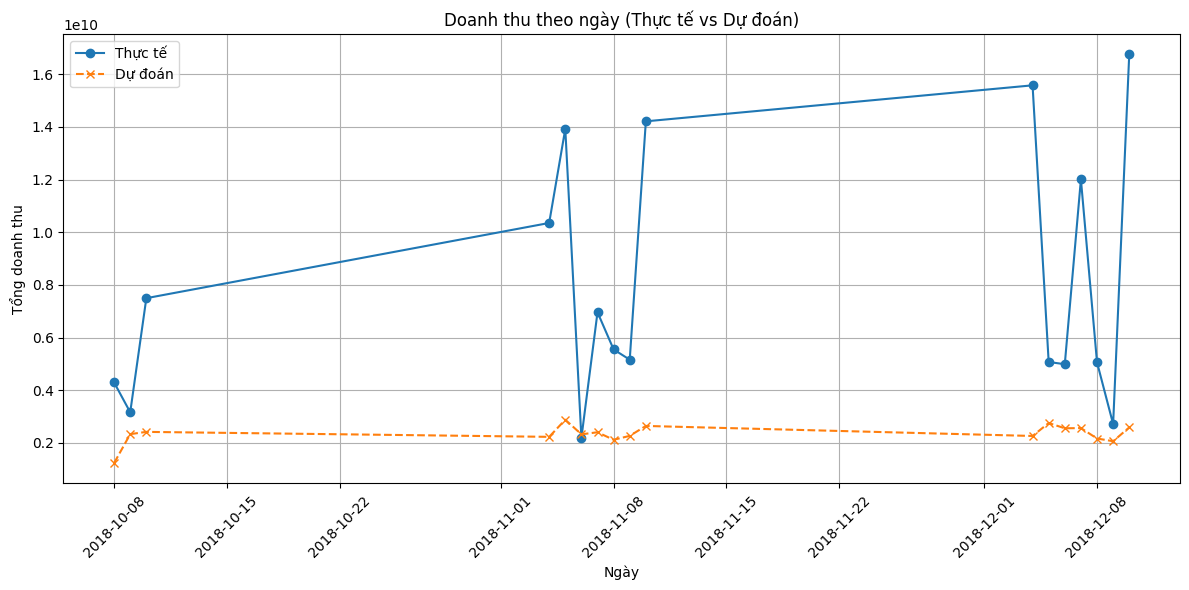

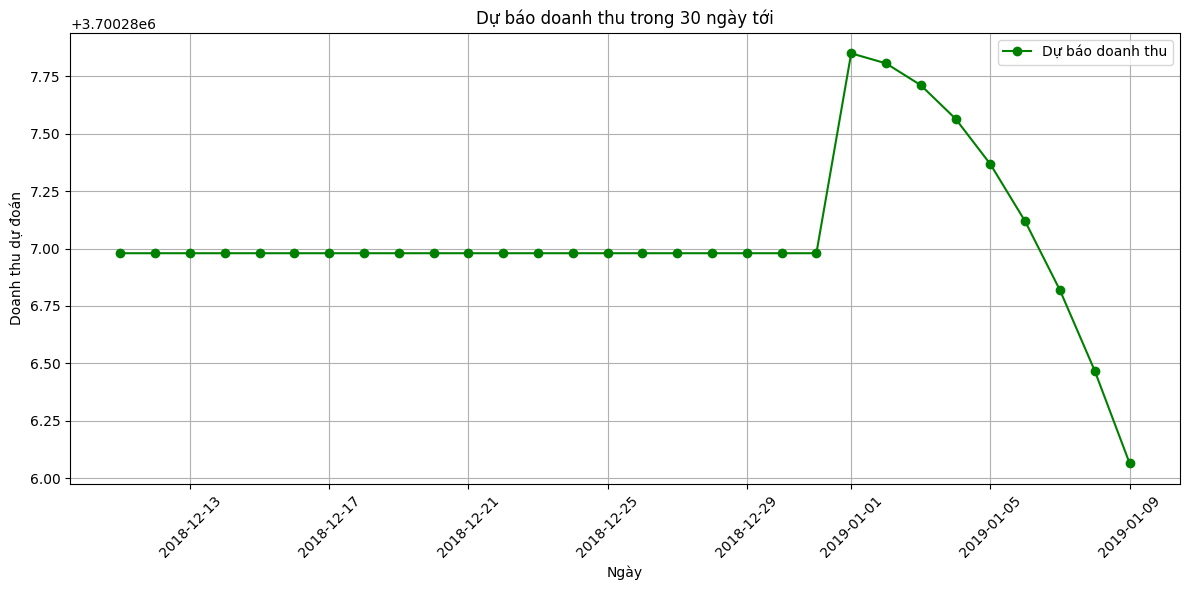

In [11]:
# 👉 Sửa đoạn scatter: dùng test_true thay vì y_test
if 'total_sales' in test_df.columns:
    test_true = test_df['total_sales'].values
    test_df['ActualSales'] = test_true
    test_df['PredictedSales'] = test_preds

    # 9. Vẽ scatter: Giá trị thực vs Dự đoán
    plt.figure(figsize=(8, 6))
    plt.scatter(test_true, test_preds, alpha=0.6, edgecolors='k')
    plt.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'r--')
    plt.xlabel('Giá trị thực')
    plt.ylabel('Giá trị dự đoán')
    plt.title('So sánh giữa thực tế và dự đoán')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("[!] Không thể vẽ scatter vì thiếu 'total_sales' trong test_df")

# 10. Vẽ doanh thu theo ngày
if 'date' in test_df.columns and 'ActualSales' in test_df.columns:
    test_df['date'] = pd.to_datetime(test_df['date'])
    
    daily = test_df.groupby(test_df['date'].dt.date).agg({
        'ActualSales': 'sum',
        'PredictedSales': 'sum'
    }).reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(daily['date'], daily['ActualSales'], label='Thực tế', marker='o')
    plt.plot(daily['date'], daily['PredictedSales'], label='Dự đoán', linestyle='--', marker='x')
    plt.xlabel('Ngày')
    plt.ylabel('Tổng doanh thu')
    plt.title('Doanh thu theo ngày (Thực tế vs Dự đoán)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[!] test_df không có cột 'date' hoặc 'ActualSales'")

# 11. Dự đoán doanh thu cho 30 ngày tiếp theo bằng SVR
if 'date' in test_df.columns:
    last_date = pd.to_datetime(test_df['date']).max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

    # Lấy mẫu dữ liệu cuối cùng để mô phỏng
    last_sample = test_df.tail(1).copy()
    future_preds = []

    for date in future_dates:
        future_sample = last_sample.copy()
        future_sample['date'] = date

        # Có thể cần chỉnh lại các cột 'month', 'day', 'year', 'quarter'
        future_sample['month'] = date.month
        future_sample['day'] = date.day
        future_sample['year'] = date.year
        future_sample['quarter'] = (date.month - 1) // 3 + 1

        # Dự đoán
        X_future, _, _, _ = preprocess(future_sample, encoders, scaler, is_train=False)
        pred = svm_model.predict(X_future)[0]
        future_preds.append(pred)

    # Tạo dataframe kết quả
    future_df = pd.DataFrame({'date': future_dates, 'PredictedSales': future_preds})

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(future_df['date'], future_df['PredictedSales'], color='green', marker='o', label='Dự báo doanh thu')
    plt.xlabel('Ngày')
    plt.ylabel('Doanh thu dự đoán')
    plt.title('Dự báo doanh thu trong 30 ngày tới')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[!] test_df không có cột 'date', không thể dự đoán tương lai.")
